In [1]:
from matplotlib import pyplot
import numpy as np
import random
import math
from IPython.display import display, Math, Latex
import matplotlib.pyplot 
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

# Equation bi-harmonique et méthode des gradients conjugués

## Cadre théorique

Afin de formuler le problème, on part de l'équation de Navier-Stokes,
$$ \frac{\partial \vec{u}}{\partial t} + \vec{u}.\vec{\nabla}\vec{u} = -\frac{1}{\rho}\vec{\nabla}P + \nu \nabla^2\vec{u} $$
La fonction vectorielle $\vec{u} = \vec{u}(\vec{x},t)$ est le champ de vitesse du fluide au point de coordonnées $\vec{x}$ et à l'instant $t$. La quantité $\vec{\nabla}\vec{u}$ est un tenseur à deux indices et '.' symbolise l'opération de contraction du tenseur. La quantité $\rho$ est la masse volumique du fluide, $P = P(\vec{x})$ la pression hydrostatique et $\nu$ la viscosité cinématique.

Le membre de gauche de l'équation contient les termes représentant l'accélération des particules de fluide, i.e. les termes inertiels. On fait ici l'hypothèse de petit nombre de Reynolds, ce qui revient à considérer que les effets d'inertie sont négligeables en regard des effets visqueux et des effets de pression. Sous ces considérations le m.d.g. de Navier-Stokes disparaît.
On applique ensuite l'opérateur rotationnel $rot = \vec{\nabla} \times $, grâce à quoi le terme de pression s'annule. En effet, 
$$ [\vec{\nabla}\times\vec{\nabla}P]_i = \epsilon_{ijk}\partial_j\partial_k P $$
les opérateur $\partial_l$ commutent,
$$\partial_j\partial_k = \partial_k\partial_j$$
puis en renommant les indices et tenant compte ensuite de la propriété d'antisymétrie du tenseur $\epsilon_{ijk}$,
$$\epsilon_{ijk}\partial_j\partial_k = \epsilon_{ijk}\partial_k\partial_j = \epsilon_{ikj}\partial_j\partial_k = -\epsilon_{ijk}\partial_j\partial_k$$
$$\Rightarrow \epsilon_{ijk}\partial_j\partial_k = -\epsilon_{ijk}\partial_j\partial_k = 0$$

De l'équation de Navier-Stokes il ne reste donc que:
$$ \vec{\nabla} \times \nabla^2 \vec{u} = 0 $$

En se rappelant la définition de la vorticité:
$$ \vec{\omega} \equiv \vec{\nabla} \times \vec{u} $$

on obtient trois équations de Laplace(I):


$$ \nabla^2 \vec{\omega} = 0$$


Par ailleurs, l'hypothèse d'incompressibilité 
$$
\vec{\nabla} . \vec{u}=0 $$

impose l'existence d'un potentiel vectoriel de courant
$$ \exists \vec{A} : \vec{\nabla}\times\vec{A}=\vec{u} $$

De plus,
$$[\vec{\nabla}\times\vec{u}]_i =[\vec{\nabla}\times\vec{\nabla}\times\vec{A}]_i = \epsilon_{ijk}\partial_j\epsilon_{klm}\partial_l A_m $$

$$=(\delta_{il}\delta_{jm}-\delta_{im}\delta_{jl})\partial_j\partial_l A_m $$

$$=\partial_j\partial_i A_j-\partial_j^2 A_i $$

$$\Rightarrow \vec{\omega} = \vec{\nabla}\times\vec{u}=\vec{\nabla}(\vec{\nabla}.\vec{A})-\nabla^2\vec{A} $$

Par choix de jauge, $\vec{\nabla}(\vec{\nabla}.\vec{A}) = 0$. On aboutit donc à trois équations de Poisson (II):
$$\nabla^2 \vec{A} = -\vec{\omega}$$

Les équations (I) et (II) se combinent comme:

$$\nabla^2 \vec{\omega} = -\nabla^2 \nabla^2 \vec{A} = 0 $$

ce qui aboutit à l'équation vectorielle suivante, dite biharmonique:

$$\nabla^4 \vec{A} = 0$$

Par la bidimensionnalité du champ de vitesse $\vec{u}$ on peut définir le potentiel de courant $\vec{A}$ tel que

$$ \vec{A} = (0,0,\psi) $$

où $\psi$ est une fonction scalaire de l'espace nommée la fonction de courant, dont les dérivées s'expriment en termes du champ de vitesse $\vec{u} = (u,v,w)$ selon:

$$\partial_y \psi = u$$
$$\partial_x \psi = -v $$

L'équation biharmonique se réduit donc à une seule équation non-triviale:

$$ \nabla ^4 \psi = 0 $$

In [2]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 10**(-8)



   ## Calcul du Super-Laplacien

Afin de résoudre l'équation bi-harmonique, nous devons tout d'abord définir un opérateur Super-Laplacien partout sur notre domaine. Celui ci se compose de dérivées pures d'ordre 4 et de dérivées mixtes d'ordre 2:
$$\nabla^4\psi = \nabla^2(\nabla^2\psi) = \nabla^2(\frac{\partial^2\psi}{\partial x^2} + \frac{\partial^2\psi}{\partial y^2} ) = \frac{\partial^4 \psi}{\partial x^4} + 2\frac{\partial^4 \psi}{\partial x^2\partial y^2} + \frac{\partial^4 \psi}{\partial y^4} $$
A l'image des dérivées secondes qui ont besoin de 3 points pour étre déterminées, les dérivées d'ordre 4 en ont besoin de 5. 

On procède conformément au cas du simple Laplacien, en développant la fonction $\psi(x,y)$ en $(x+\Delta x , y)$ et en $(x,y+\Delta y)$ à la nuance près que nous allons jusqu'à l'ordre 4 pour faire apparaître les dérivées qui nous intéressent.
Afin d'alléger l'écriture nous n'indiquerons dans le raisonnement ci-dessous, que la dépendance en la variable vis-à-vis de laquelle on développera la fonction.

$$\psi(x+\Delta x ) =\psi(x)+\psi'(x)\Delta x +\psi''(x)\Delta x^2/2+\psi'''(x)\Delta x^3/6+\psi''''(x)\Delta x^4/24$$
$$\psi(x-\Delta x ) =\psi(x)-\psi'(x)\Delta x +\psi''(x)\Delta x^2/2-\psi'''(x)\Delta x^3/6+\psi''''(x)\Delta x^4/24$$

Nous n'avons ici que deux équation, ce qui ne nous permet pas de définir $\frac{\partial^4\psi(x)}{\partial x^4}$ uniquement en fonction des valeurs de $\psi$. En effet en additionant ces deux lignes on élimine les termes contenant des dérivées d'ordre impair et on obtient une première équation (III):
$$\psi(x +\Delta x)+\psi(x-\Delta x)=2\psi(x)+\psi''(x)\Delta x^2+\psi''''(x)\Delta x^4/12 $$

Il nous faut donc d'autres équations afin d'éliminer les dérivées d'ordre 2.

Elles s'obtiennent en estimant la fonction un peu plus loin que ce que nous avons fait, en $x+2\Delta x$ par exemple : 


$$\psi(x-2\Delta x ) =\psi(x)-2\psi'(x)\Delta x +2\psi''(x)\Delta x^2-\frac{4}{3}\psi'''(x)\Delta x^3+\frac{2}{3}\psi''''(x)\Delta x^4$$
$$\psi(x+2\Delta x ) =\psi(x)+2\psi'(x)\Delta x +2\psi''(x)\Delta x^2+\frac{4}{3}\psi'''(x)\Delta x^3+\frac{2}{3}\psi''''(x)\Delta x^4$$

De même, en additionant ces deux lignes on obtient une seconde équation (IV):

$$\psi(x+2\Delta x)+\psi(x-2\Delta x)=2\psi(x)+4\psi''(x)\Delta x^2+\frac{4}{3}\psi''''(x)\Delta x^4$$


Nous avons maintenant assez pour éliminer totalement les dérivées secondes de l'expression de $\psi''''(x)$. On le fait au moyen de l'opération (IV) - 4(III), d'où:

$$\psi(x+2\Delta x)+\psi(x-2\Delta x)-4\psi(x+\Delta x)-4\psi(x-\Delta x)=-6\psi(x)+\psi''''(x)\Delta x^4 $$

Finalement,

$$\frac{\partial^4 \psi(x,y)}{\partial x^4} \leftarrow \psi''''(x)=\frac{1}{\Delta x^4}\big(\psi(x+2\Delta x)+\psi(x-2\Delta x)-4\psi(x+\Delta x)-4\psi(x-\Delta x)+6\psi(x)\big) $$

Et voilà, nous avons implémenté au point $x$ la dérivée d'ordre 4, en utilisant uniquement les valeurs prises par la fonction $\psi$ dans un voisinage de $x$.

La dérivée selon y s'obtient de la même façon.

Pour les dérivées mixtes, nous procédons légèrement différement. Nous n'avons pas envie de nous ennuyer à devoir développer $\psi(x+\Delta x, y+\Delta y)$ autour de $(x,y)$ jusqu'à l'ordre 4 (par exemple). À la place nous calculons d'abord la dérivée d'ordre deux selon x ou y - peu importe, de manière tout à fait classique ("central difference scheme") : 

$$\frac{\partial^2 \psi}{\partial x^2}(x,y)=(\psi(x+\Delta x,y)+\psi(x-\Delta x,y) - 2\psi(x,y))/\Delta x^2 $$

Nous définissons ensuite une nouvelle fonction g selon $g(x,y)=\frac{\partial^2\psi}{\partial x^2}(x,y)$

Maintenant nous prenons la dérivée seconde de g selon y : 

$$\frac{\partial^2 g}{\partial y^2}(x,y)=(g(x,y+\Delta y)+g(x,y-\Delta y) - 2g(x,y))/\Delta x^2 $$

Si l'on décompose g (mais il faut vraiment en avoir envie car ce n'est pas très agréabla à l'oeil) on a :

$$\frac{\partial^4 \psi}{\partial x^2 \partial y ^2}(x,y)=\Big(\psi(x+\Delta x, y + \Delta y )+ \psi(x-\Delta x,y+\Delta y)-2\psi(x,y+\Delta y) + \psi(x+\Delta x, y-\Delta y)+\psi(x-\Delta x,y-\Delta y)-2\psi(x,y-\Delta y)-2\psi(x+\Delta x ,y)-2\psi(x-\Delta x, y) +4\psi(x,y) \Big)/\Delta x^2\Delta y^2 $$

Notons qu'il faut prendre deux fois cette contribution dans le Super-Laplacien. Nous avons d'ailleurs tout en main pour implémenter celui-ci.

## Implémentation 

In [3]:
def super_laplacian(A,nx,ny,dx,dy):
    g_xx=np.zeros_like(A) 
    g_yy=np.zeros_like(A)          #On initialise les 3 matrices qui contiendront les valeurs des dérivées pures
    g_xy=np.zeros_like(A)          #en x et en y et les valeurs de la dérivée mixte, sur tout le domaine [nx-4].[ny-4].dx.dy 
    g_tot=np.zeros_like(A)         #On initialise aussi g_tot qui contiendra les valeurs du Super-Laplacien sur le domaine.
    for n in range (2,nx-2):
        for m in range(2,ny-2):
            g_xx[n,m]=(A[n+2,m]+A[n-2,m]-4*A[n+1,m]-4*A[n-1,m]+6*A[n,m])/dx**4
            g_yy[n,m]=(A[n,m+2]+A[n,m-2]-4*A[n,m+1]-4*A[n,m-1]+6*A[n,m])/dy**4
            g_xy[n,m]=2*(A[n+1,m+1]+A[n-1,m+1]-2*A[n,m+1]+A[n+1,m-1]+A[n-1,m-1]-2*A[n,m-1]-2*A[n+1,m]-2*A[n-1,m]+4*A[n,m])/((dx**2)*(dy**2))
            g_tot[n,m]=g_xx[n,m]+g_yy[n,m]+g_xy[n,m]
    return g_tot[2:-2,2:-2]

On se donne des conditions de Neuman sur la fonction de courant $\psi$ au bord du domaine d'aire $n_x.n_y.dx.dy$. Il s'agit bien de conditions de Neuman sur $\psi$ puisque ce sont des conditions sur la valeur du champ de vitesse $\vec{u} = (u,v,w)$, dont les composantes sont données par les fonctions $\partial_i\psi$.
Les conditions sont $u = 1$ en $y = n_y.dy$, $u = 0$ en $y = 0$, $v = 0$ en $x = 0$ et $x = n_x.dx$. En termes des dérivées de $\psi$:

$\partial_y \psi = 1$ en $y = n_y.dy$;
$\partial_y \psi =  0$ en $y = 0$;
$\partial_x \psi = 0$ en $x = 0$;
$\partial_x \psi = 0$ en $x = n_x.dx$.

Une petite subtilité: on implémentera les conditions de Neuman sous forme de conditions de Dirichlet, i.e. sur les valeurs de la fonction $\psi$ au bord. Pour y arriver, voici le calcul que nous avons fait. Ici nous considérons $y = 0$ et traitons $\psi$ comme une fonction à une seule variable $y$.

$$\psi(y+\Delta y) = \psi(y) + \psi'(y)\Delta y  + \psi''(y)\frac{\Delta y^2}{2} + O(\Delta y^3)$$
$$\psi(y+2\Delta y) = \psi(y) + 2 \psi'(y)\Delta y + \psi''(y)\frac{(2\Delta y)^2}{2} + O(\Delta y^3)$$

$$\Rightarrow \psi(y + 2 \Delta y) - 4\psi(y + \Delta y) = -3 \psi(y) - 2 \psi'(y)\Delta y $$

$$\Rightarrow \psi(y = 0) = \frac{1}{3}\Big( 4 \psi(y = \Delta y) - \psi(y = 2\Delta y) - 2 \psi'(y = 0)\Delta y \Big) $$

Or on impose la condition $\psi'(y = 0) = 0$ donc
$$\psi(y = 0) = \frac{1}{3}\Big( 4 \psi(y = \Delta y) - \psi(y = 2\Delta y) \Big) $$

Idem pour $x = 0$, en faisant le changement $y \rightarrow x $.

Pour $y = n_y.\Delta y$, le calcul est légèrement différent:

$$\psi(y-\Delta y) = \psi(y) - \psi'(y)\Delta y + \psi''(y)\frac{\Delta y^2}{2} + O(\Delta y^3)$$
$$\psi(y-2\Delta y) = \psi(y) - 2\psi'(y)\Delta y + \psi''(y)\frac{(2\Delta y)^2}{2} + O(\Delta y^3)$$

$$\Rightarrow \psi(y - 2 \Delta y) - 4\psi(y - \Delta y) = -3 \psi(y) + 2\psi'(y)\Delta y $$

$$\Rightarrow \psi(n_y.\Delta y) = \frac{1}{3}\Big( 4 \psi((n_y-1).\Delta y) - \psi((n_y-2).\Delta y) + 2 \Delta y \Big) $$
en tenant compte de la condition $\psi'(n_y.\Delta y) = 1$.

Pour $x = n_x.\Delta x$ le résultat est légèrement différent car la condition est $\psi'(x = n_x.\Delta x) = 0$ donc on n'a pas le terme $2 \Delta x$.

In [4]:
def L1_norm(new, old):            #Une fonction qui donne la norme de la différence entre deux solutions 
    norm = np.sum(np.abs(new-old))
    return norm

## Gradients conjugués et solution 

Afin de résoudre l'équation bi-harmonique, nous utilisons la méthode des gradients conjugués. Celle-ci est exposée dans le MOOC qui nous est donné et nous n'avons, pour notre problème, que peu de choses à modifier dans le code fourni. Nous présenterons donc un code quasi-identique à celui du MOOC. Par honnêteté, nous avons gardé les mêmes noms pour les variables et autres éléments intervenant dans le code. Les modifications à apporter sont les suivantes: tout d'abord, l'opérateur à utiliser ici est le Super-Laplacian que nous avons défini plus haut. De plus il faut faire attention à ce que le résidu, de même que la matrice de recherche aient $ (n_x-2)\times(n_y-2) $ élèments sur lesquels porte l'itération ( au lieu de $ (n_x-1)\times(n_y-1)$ ) pour l'équation avec un simple Laplacien). Finalement, nous avons introduit à la fin du code les conditions de Neuman - détaillées précédemment, que la solution doit satisfaire.

In [5]:
def poisson_2d_conjugate_gradient(p0,dx, dy,maxiter, rtol) : 
    
    p=p0.copy()
    r = np.zeros_like(p)  # Résidu initial
    Ad = np.zeros_like(p)  # Une matrice pour stocker le super-laplacien 
    conv = []   #Liste qui servira à consulter la norme de la différence entre 2 solutions succéssives
    diff = rtol + 1  # Différence initiale 
    ite = 0  # Index de l'itération
    
    # Le résidu initial ( le terme de source est nul)
    
    r[2:-2, 2:-2] =-super_laplacian(p,nx,ny,dx,dy)

    # La première matrice de recherche est notre résidu
    d = r.copy()
    while diff > rtol and ite < maxiter:
        pk = p.copy()
        rk = r.copy()
        
        # on prend le super-laplacien de notre matrice de recherche 
        
        Ad[2:-2, 2:-2] = super_laplacian(d,nx,ny,dx,dy)
        
        # on attribue la taille du pas
        
        alpha = np.sum(r * r) / np.sum(d * Ad)
        
        # on itère la solution 
        p = pk + alpha * d
        
        # on itère le résidu 
        r = rk - alpha * Ad
        
        # On itère la matrice de recherche
        beta = np.sum(r * r) / np.sum(rk * rk)
        d = r + beta * d
        
       
        # On prend la norme, on l'ajoute au tableau conv et on augmente de 1 le nombre d'itérations
        diff = L1_norm(p, pk)
        conv.append(diff)
        ite += 1
        
        # on implémene les conditions de Neuman.
        
        p[:,0]=4*p[:,1]/3-p[:,2]/3
        p[0,:]=4*p[1,:]/3-p[2,:]/3
        p[-1,:]=-p[-3,:]/3+4*p[-2,:]/3
        p[:,-1]=2*dy/3-p[:,-3]/3+4*p[:,-2]/3
                                                         
    return p , ite, conv

In [6]:
A_1 = np.zeros((nx,ny)) #Conditions initiales

A_1[:,-1]=1

A_final, nbr , converg = poisson_2d_conjugate_gradient(A_1, dx, dy,maxiter=40000, rtol=1e-8)
A_f=np.transpose(A_final)

Nous avons pris la transposée de notre solution car Python interprète les élèments [i,j] d'une matrice (notation conventionnelle) comme les éléments [j,i]. Si l'on ignore cette étape, les axes x et y sont inversés sur le plot. Ce faisant nous obtenons ce premier plot.

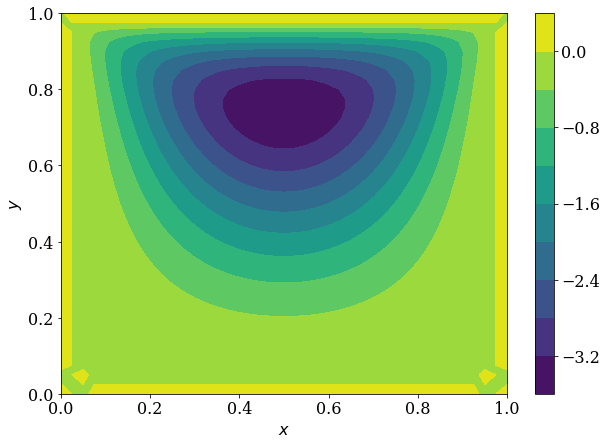

In [7]:
x = np.linspace(0,l,nx)  
y = np.linspace(0,l,ny)
pyplot.figure(figsize=(10,7))
pyplot.contourf(x,y,A_f,11,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

Il n'est pas trop mal mais nous voyons qu'il se passe des choses un peu étrange au bord. Est-ce si surprenant ? Pas tellement, rappelons-nous que pour calculer le Super-Laplacien nous avions besoin de points à $2\Delta x$ d'écart, ce pourquoi le Super-Laplacien n'était pas défini sur les bords. Les points des bandes de largeur $2\Delta x$  n'interviennent pas dans notre recherche de solution avec la méthode des gradients conjugués et donc rien n'indique qu'ils correspondent bien à la solution. Ainsi, nous ré-effectuons notre plot en excluant ces points. À noter que nous aurions pu calculer le Super-Laplacien sur les bords (dans les coins il aurait probablement fallu un peu tricher). Il aurait suffit de calculer les dérivées quatrièmes non plus centrées comme nous l'avons fait mais forward ou backward selon que l'endroit que nous considérions sur le cadre. Nous avons cependant jugé que cela n'apporterait rien à la compréhension du problème. Voici donc le Plot final:

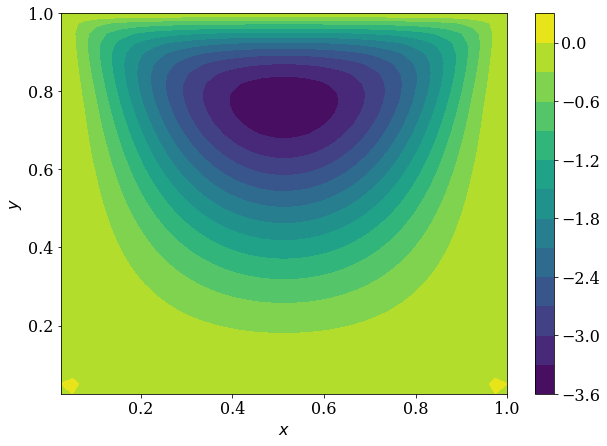

In [8]:
x = np.linspace(dx,l,nx-2)  
y = np.linspace(dy,l,ny-2)
pyplot.figure(figsize=(10,7))
pyplot.contourf(x,y,A_f[1:-1,1:-1],11,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

Donnons-nous enfin les valeurs de $\psi$ aux points (0.6,0.2) ; (0.6,0.4) ; (0.6,0.6) ; (0.6,0.8).

In [9]:
print(0.6/dx)
print(0.2/dx)
print(0.4/dx)
print(0.8/dx)

23.999999999999996
8.0
16.0
32.0


In [10]:
print(A_f[24,8],A_f[24,16],A_f[24,24],A_f[24,32])

-1.21428681645 -2.70725826758 -2.70725826758 -1.21428681645


On se donne aussi les coordonnées du minimum et sa valeur.

In [11]:
A_min = A_f[0,0]
k = 0
l = 0
for i in range (2,nx-3):
    for j in range (2,ny-3):
        if A_f[i,j] < A_min:
            A_min = A_f[i,j]
            k = i
            l = j
print(A_min)
print(k*dx,l*dy)

-3.55744865574
0.75 0.5


## Conclusion

Concluons. On a tout d'abord implémenté l'opérateur Super-Laplacien. Ensuite, nous avons utilisé la méthode des gradients conjugués afin de résoudre l'équation biharmonique sur un domaine carré, ce qui revenait à déterminer la fonction de courant $\psi(x,y)$ sur le domaine. En appliquant cette méthode, on a imposé des conditions de Neuman sur les bords, qui correspondent au glissement constant d'une plaque sur le bord supérieur du carré.
Faisons quelques remarques sur la solution obtenue.

Tout d'abord, $\psi$ admet un minimum global au point de coordonnée $(0.5,0.75)$. Or, par définition le champ de vitesse $\vec{u} = (u,v)$ est donné par le rotationnel de $\psi$, et donc les composantes $u$ et $v$ sont données en termes des dérivées de $\psi$. Par conséquent, les dérivées de $\psi$ étant nulles au minimum, le champ de vitesse est lui-même nul en ce point.

Ensuite, on voit que sous le minimum de $\psi$, la dérivée selon $y$ est négative donc la composante $u$ du champ de vitesse est négative, i.e. les lignes de courant sont orientées vers la gauche. Au-dessus du minimum, la dérivée selon $y$ est positive donc le champ de vitesse va vers la droite. Par un raisonnement similaire sur les dérivées selon $x$, on obtient que les lignes de courant ont tendance à s'orienter vers le haut à gauche du minimum et vers le bas à sa droite. On a donc un champ de vitesse qui tourne dans le sens horlogique autour d'un point où le fluide ne bouge pas.

Enfin, la vitesse horizontale du fluide au-dessus du minimum (de la fonction de courant) est plus grande qu'en-dessous de celui-ci. On le voit au fait que les courbes de niveau sont beaucoup plus rapprochées, signifiant que la dérivée selon $y$ prend des valeurs plus élevées que dans la zone inférieure. Cela s'explique par le fait que le fluide y est plus proche de la plaque en mouvement, qui lui imprime une vitesse vers la droite.